In [107]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn


with open('./如梦令.txt', 'r', encoding='utf-8') as f:
    data = f.read()

words = list(set(data))
word2ind = {word: i for i, word in enumerate(words)}
ind2word = {i: word for i, word in enumerate(words)}


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        #===========由上一个的hidden传给下一个time step的hidden
        self.h2h = nn.Linear(hidden_size, hidden_size)
        #===正常传播=====================================
        self.in2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        #==============================================
        self.drop = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()

    def forward(self, inputs, hidden):
        #==================正常传播=======================================
#         input_combined = torch.cat((inputs.float(), hidden.float()), 0)
        hidden = self.in2h(inputs)
        output = self.h2o(hidden)
        output = self.drop(output)
        output = self.softmax(output)
        #================================================================
        #===============将hidden传给下一个time step========================
        hidden_next = self.h2h(hidden)
        #================================================================
        return output, hidden_next

    def init_hidden(self):
        return Variable(torch.from_numpy(np.zeros((self.input_size, self.hidden_size))).type(torch.FloatTensor)).cuda()

def form_onehot(sent):
    one_hot = np.zeros((len(data), len(words)), dtype=np.int64)
    for i, word in enumerate(sent):
        one_hot[i, word2ind[word]] = 1
    return torch.LongTensor(one_hot)

#should pass a softmax result vector in
def random_choice(vec):
    return np.random.choice(list(range(len(words))), p=vec)

def train(rnn, learning_rate, criterion, optimizer, input_tensor, target_tensor, max_iter):
    all_loss = []
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
#     for i in range(input_tensor.size(0)-1):
    for i in range(max_iter):
        output, hidden = rnn(input_tensor, hidden)
        loss = criterion(output, target_tensor)
        loss.backward(retain_variables=True)
        optimizer.step()
        if i % 5 == 0:
            all_loss.append(loss)
            print('epoch: '+str(i)+' loss: '+str(loss))
    all_loss = np.array(all_loss)
    return output, all_loss, hidden

In [108]:
len(data)

6273

In [109]:
onehot_data = form_onehot(data)
print(onehot_data.size(), len(words))

torch.Size([6273, 1139]) 1139


In [119]:
rnn = RNN(len(words), 10, len(words)).cuda()
print('Input size: '+str(len(words))+'. Hidden size: '+str(10)+'. Output size: '+str(len(words)))
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

Input size: 1139. Hidden size: 10. Output size: 1139


In [120]:
#input和output必须都是Variable
input_tensor = Variable(onehot_data[:-1, :].type(torch.FloatTensor)).cuda()
print(input_tensor.size(), onehot_data.size())
target = []
for i in range(onehot_data[1:, :].size(0)):
    ind = onehot_data[i, :].numpy().tolist().index(1.)
    target.append(ind)
#     target.append(Variable(torch.from_numpy(np.array([ind])).type(torch.LongTensor)).cuda())
target = Variable(torch.from_numpy(np.array(target)).type(torch.LongTensor)).cuda()
print(target.size())

torch.Size([6272, 1139]) torch.Size([6273, 1139])
torch.Size([6272])


In [ ]:
output, loss, hidden = train(rnn, learning_rate, criterion, optimizer, input_tensor, target, 40)

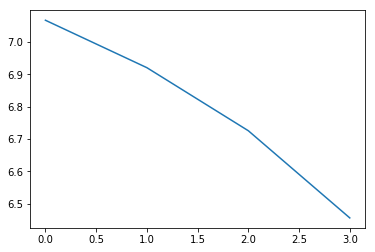

In [123]:
l = []
for i in loss.squeeze():
#     i.data.cpu()
    l.append(i.data.cpu().numpy())
plt.plot(l)
plt.show()

In [124]:
output_prob = output.data.cpu().numpy()

In [99]:
# np.savetxt('./rnnOutput.txt', output_prob)
np.savetxt('./hidden_new.txt', hidden.data.cpu().numpy())

In [126]:
p = output.cpu().data.numpy().squeeze()
p -= np.min(p)
p /= np.max(p)
# p -= np.mean(p)

In [140]:
output_ci = ''
inputs = input_tensor[0, :]
for i in range(40):
    output, hidden = rnn(inputs.unsqueeze(0), hidden)
    p = output.cpu().data.numpy().squeeze()
    p -= np.min(p)
    p /= np.sum(p)
    choice = np.random.choice(range(len(words)), p=p)
    output_ci += ind2word[choice]
    inputs = input_tensor[word2ind[words[i]], :]

In [141]:
print(output_ci)

俯甚奈嫩额琼亚杏萼岩绫唤晴限家著谪英阁除故开语美销冷足报何两触吹依将歌起层你谢）


In [118]:
with open('./tttttttttttt.txt', 'w', encoding='utf-8') as f:
    f.write(output_ci)

In [115]:
out = output_ci[:6]+'。'+output_ci[6:12]+'，'+output_ci[12:17]+'。'+output_ci[17:23]+'。'+output_ci[23:25]+'，'+output_ci[25:27]+'。'+output_ci[27:33]

In [143]:
import tkinter as tk
import tkinter.messagebox

def getPoetry():
    txt = title_in.get()
    output = output_ci
#     print(output, type(output))
    t.delete('1.0', '2.0')
    t.insert('1.0', output_ci)


# 庆春， 腊梅香， 清朝， 菩萨， 浣溪沙
win = tk.Tk()
var = tk.StringVar()
var.set("如梦令")
title_in = tk.Entry(win, textvariable  = var)
title_in.pack()
t = tk.Text(win, )

t.pack()

button_get = tk.Button(win, text="生成宋词", command=getPoetry)
button_get.pack()
win.mainloop()